In [ ]:
!pip install pywaffle
!pip install statsmodels

# Import & Configs

In [ ]:
# read files
from google.colab import drive

# data processing
from collections import Counter
from itertools import combinations
import pandas as pd
import ast

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle

# statistics
import statsmodels.api as sm
from scipy.stats import f_oneway

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ajustando Dataset

In [ ]:
path = "/content/drive/MyDrive/estat/segundo_semestre/icc/trabalho_final/datasets/"

netflix_kaggle = pd.read_csv(f"{path}raw/netflix_movies.csv", index_col=[0])
netflix = netflix_kaggle.copy()

In [192]:
# Transformando as strings dentro das linhas em Listas
netflix['production_countries'] = netflix['production_countries'].apply(ast.literal_eval)
netflix['genres'] = netflix['genres'].apply(ast.literal_eval)

In [ ]:
# Dropando colunas desnecessárias

'''
1. imdb_id: Como não será feito nenhum merge, a coluna torna-se
            desnecessária, ao passo que já temos outro index
            na tabela.

2. description: Não será utilizado LLM's ou qualquer outra técnica
                de NLP. Sendo assim, será removida

3. age_certification: Ao passo que a trabalho não se aprofunda em
                      conceitos técnicos do tema abordado pelo
                      dataset, mas sim, nas técnicas de análise de
                      dados, não se faz interessante o uso de tal
                      informação.
'''

netflix.drop(["imdb_id", "description", "age_certification"], axis=1, inplace=True)

In [ ]:
# Corrigindo o tipo das colunas

netflix['imdb_votes'] = netflix['imdb_votes'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
netflix['imdb_votes'] = netflix['imdb_votes'].astype('Int64')

# Metadados

This dataset contains +5k unique titles on Netflix with 15 columns containing their information, including:

*   id: The title ID on JustWatch.
*   title: The name of the title.
*   show_type: TV show or movie.
*   description: A brief description.
*   release_year: The release year.
*   age_certification: The age certification.
*   runtime: The length of the episode (SHOW) or movie.
*   genres: A list of genres.
*   production_countries: A list of countries that produced the title.
*   seasons: Number of seasons if it's a SHOW.
*   imdb_id: The title ID on IMDB.
*   imdb_score: Score on IMDB.
*   imdb_votes: Votes on IMDB.
*   tmdb_popularity: Popularity on TMDB.
*   tmdb_score: Score on TMDB.


In [ ]:
print("Tipagem das Colunas:\n")
netflix.dtypes

Tipagem das Colunas:



title                    object
type                     object
release_year              int64
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_score              float64
imdb_votes                Int64
tmdb_popularity         float64
tmdb_score              float64
dtype: object

# Análise Geral

## Dataset Original - Kaggle

In [ ]:
netflix_kaggle.head()

,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [ ]:
print(f"n° de linhas: {netflix_kaggle.shape[0]}\nn° de colunas: {netflix_kaggle.shape[1]}")

n° de linhas: 5850
n° de colunas: 14


In [ ]:
print("Colunas:\n")
for index, col in enumerate(netflix_kaggle.columns):
  print(f'{index+1}. {col}')

Colunas:

1. title
2. type
3. description
4. release_year
5. age_certification
6. runtime
7. genres
8. production_countries
9. seasons
10. imdb_id
11. imdb_score
12. imdb_votes
13. tmdb_popularity
14. tmdb_score


In [ ]:
print("Nulos por Colunas: \n")
netflix_kaggle.isna().sum()

Nulos por Colunas: 



title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

In [ ]:
total_nulos = netflix_kaggle.isna().sum().sum()
total_infos = netflix_kaggle.shape[0] * netflix_kaggle.shape[1]

print(f"Percentual de Informações nulas --> {round(total_nulos/total_infos*100, 2)}%")

Percentual de Informações nulas --> 9.97%


## Dataset Recortado


In [ ]:
netflix.head(4)

,title,type,release_year,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,
ts300399,Five Came Back: The Reference Films,SHOW,1945,51,[documentation],[US],1.0,NaN,<NA>,0.600,NaN
tm84618,Taxi Driver,MOVIE,1976,114,"[drama, crime]",[US],NaN,8.2,808582,40.965,8.179
tm154986,Deliverance,MOVIE,1972,109,"[drama, action, thriller, european]",[US],NaN,7.7,107673,10.010,7.300
tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,"[fantasy, action, comedy]",[GB],NaN,8.2,534486,15.461,7.811


In [ ]:
print(f"n° de linhas: {netflix.shape[0]}\nn° de colunas: {netflix.shape[1]}")

n° de linhas: 5850
n° de colunas: 11


In [ ]:
print("Colunas:\n")
for index, col in enumerate(netflix.columns):
  print(f'{index+1}. {col}')

Colunas:

1. title
2. type
3. release_year
4. runtime
5. genres
6. production_countries
7. seasons
8. imdb_score
9. imdb_votes
10. tmdb_popularity
11. tmdb_score


In [ ]:
print("Nulos por Colunas: \n")
netflix.isna().sum()

Nulos por Colunas: 



title                      1
type                       0
release_year               0
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

In [ ]:
total_nulos = netflix.isna().sum().sum()
total_infos = netflix.shape[0] * netflix.shape[1]

print(f"Percentual de Informações nulas --> {round(total_nulos/total_infos*100, 2)}%")

Percentual de Informações nulas --> 7.97%


<ipython-input-97-9c855d2c1a80>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_axis)


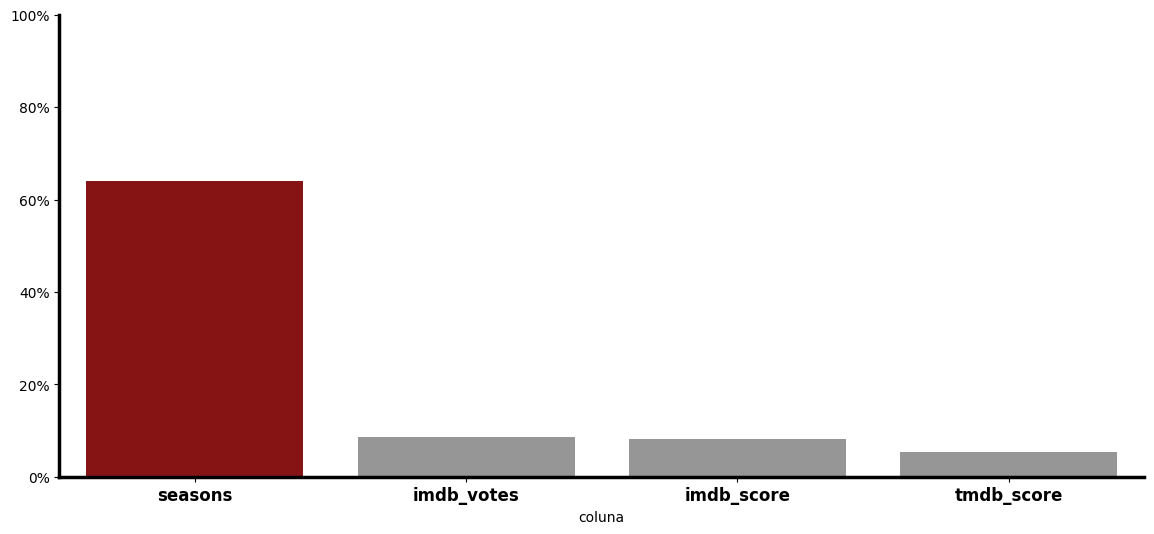

In [ ]:
# Ajustando DataFrame
df_nulls = pd.DataFrame(netflix.isna().sum() / netflix.shape[0]).reset_index()
df_nulls = df_nulls.rename(columns={"index": "coluna", 0: "contagem_nulos"})
df_nulls = df_nulls.sort_values(by="contagem_nulos", ascending=False)
df_nulls = df_nulls[df_nulls["contagem_nulos"] > 0.05]

##### Plotando Gŕafico

# Ajustando Cores
cinza_escuro = (150/255, 150/255, 150/255)
cores = ['#990101' if i < 1 else cinza_escuro for i in range(len(df_nulls['coluna']))]

plt.figure(figsize=(14,6))
plt.ylim(0,1)

ax = sns.barplot(data=df_nulls, x="coluna", y="contagem_nulos", palette=cores)

plt.xticks(fontsize = 12, fontweight = 'bold', color = "black")

y_axis = [f"{x}%" for x in range(0, 101, 20)]
ax.set_yticklabels(y_axis)

plt.ylabel('', fontsize=15)

plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom = False, left = False)

ax = ax


# Análise por Colunas

Análise específica, buscando padrões nas informações contidas nas colunas

## Release Year

In [ ]:
netflix.sort_values(by="release_year", inplace=True, ascending=True)
print(f"Produção mais antiga: ### {netflix.iloc[0]['title']} ### de {netflix.iloc[0]['release_year']}\nProdução mais recente: ### {netflix.iloc[-1]['title']} ### de {netflix.iloc[-1]['release_year']} ")

Produção mais antiga: ### Five Came Back: The Reference Films ### de 1945
Produção mais recente: ### No Regrets In Life ### de 2022 


In [ ]:
print("Quantidade de produções por Década:\n ")
prod_p_decade = pd.value_counts(pd.cut(netflix.release_year, bins=(range(1940, 2031, 10))))
prod_p_decade

Quantidade de produções por Década:
 


(2010, 2020]    4052
(2020, 2030]    1158
(2000, 2010]     424
(1990, 2000]     125
(1980, 1990]      56
(1970, 1980]      21
(1960, 1970]       7
(1950, 1960]       6
(1940, 1950]       1
Name: release_year, dtype: int64

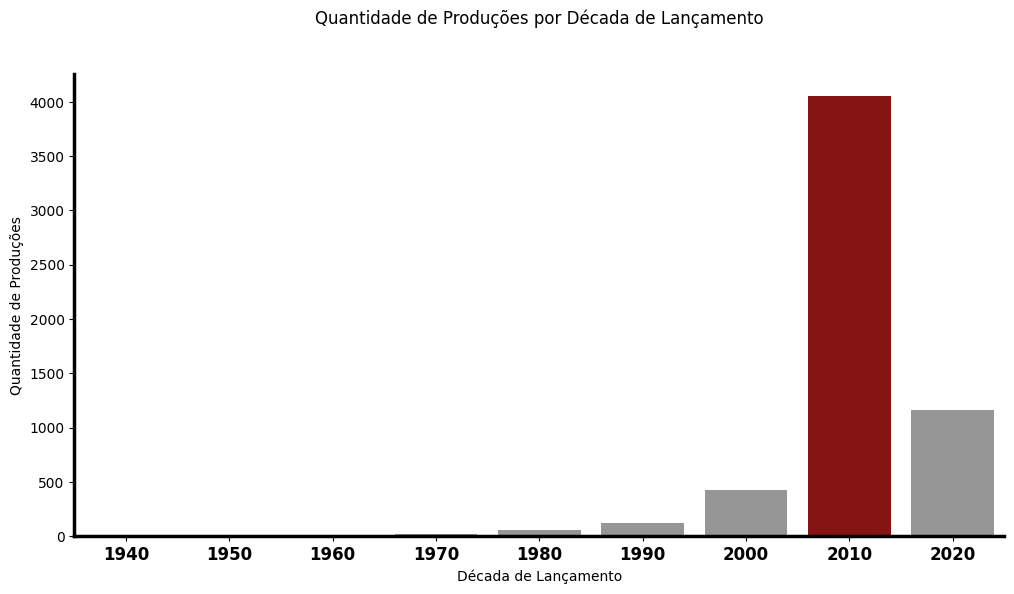

In [ ]:
prod_p_decade = pd.DataFrame(prod_p_decade).reset_index()

# Ajustando Cores
cinza_escuro = (150/255, 150/255, 150/255)
cores = ['#990101' if i == 7 else cinza_escuro for i, _ in enumerate(prod_p_decade['index'])]

plt.figure(figsize=(12,6))
ax = sns.barplot(data=prod_p_decade, x="index", y="release_year", palette=cores)

plt.xlabel("Década de Lançamento")
plt.ylabel("Quantidade de Produções")
plt.title("Quantidade de Produções por Década de Lançamento\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")

# Alterando os Rótulos
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text().split(',')[0][1:] for label in ax.get_xticklabels()])

plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

ax = ax

plt.show()


MOVIE --> Vermelho
SHOW --> Cinza


<ipython-input-101-dffc5b704fe0>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


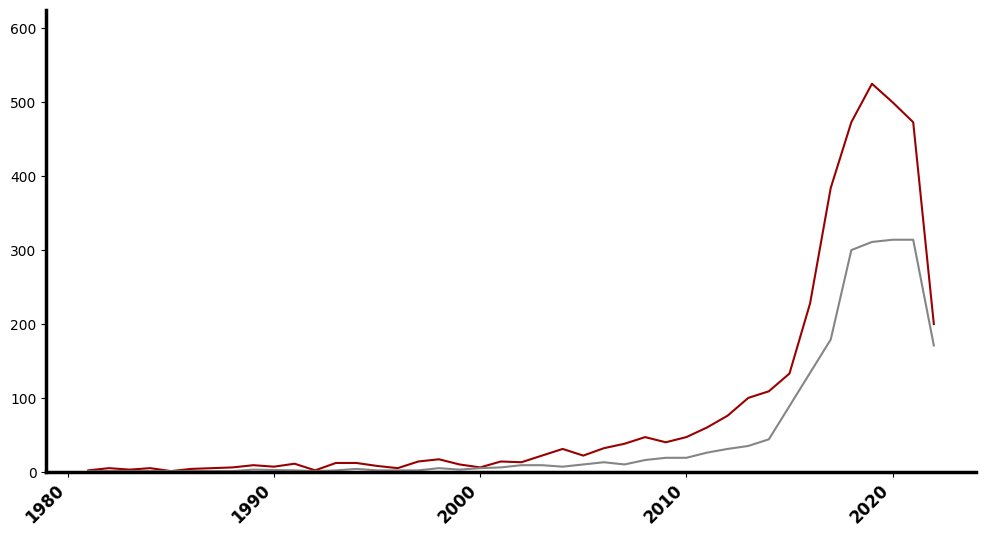

In [ ]:
# Selecionando os mais recentes, ao passo que não há uma amostra significativas
# dos dados passados
grouped_types = netflix.groupby(["release_year", "type"]).count()
grouped_types = grouped_types.reset_index()
grouped_types = grouped_types[grouped_types.release_year > 1980]


# texto
print("MOVIE --> Vermelho\nSHOW --> Cinza")

# gráfico
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=grouped_types, x='release_year', y="title", hue="type", palette=['#990101', '#858585'])

plt.xticks(fontsize = 12, fontweight = 'bold', color = "black")
plt.rcParams["axes.linewidth"] = 2.50
plt.xlabel('')
plt.ylabel('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


sns.despine(bottom = False, left = False)
plt.legend().remove()

ax.set_ylim(0, grouped_types.title.max()+100)

ax = ax

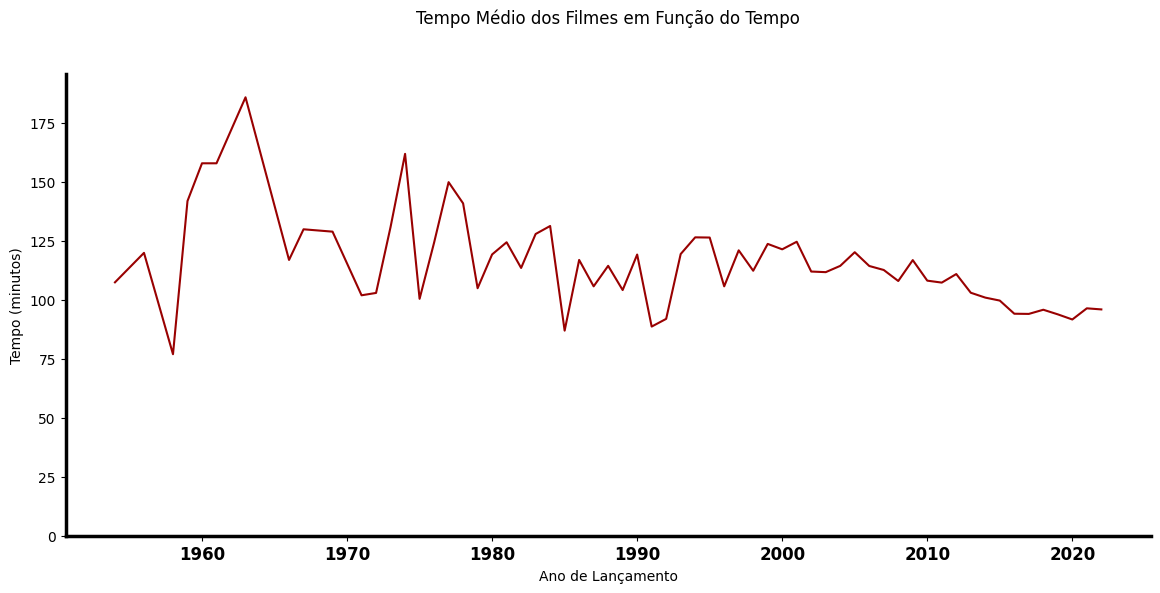

In [ ]:
grouped_runtime = netflix[netflix["type"] == "MOVIE"]
grouped_runtime = grouped_runtime.groupby("release_year")["runtime"].mean()
grouped_runtime = pd.DataFrame(grouped_runtime).reset_index()

# gráfico
plt.figure(figsize=(14, 6))

sns.lineplot(data=grouped_runtime, x='release_year', y="runtime", color='#990101')

plt.xlabel('Ano de Lançamento')
plt.ylabel('Tempo (minutos)')
plt.title("Tempo Médio dos Filmes em Função do Tempo\n\n")

# Ajustando Eixos
plt.ylim(0, grouped_runtime["runtime"].max() + 10)
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

plt.show()

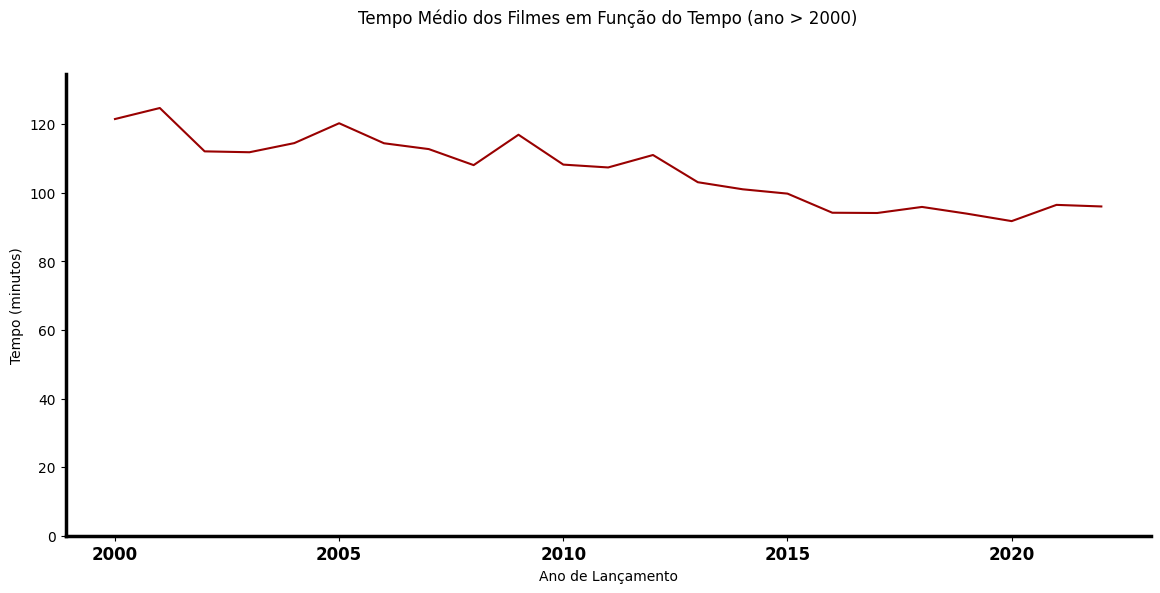

In [ ]:
# Semelhante ao gráfico acima, porém somente com as produções mais recentes
# ao passo que o dataset contém poucas informações de filmes antigos, podendo
# enviesar a análise
grouped_runtime = netflix[(netflix["type"] == "MOVIE") & (netflix["release_year"] >= 2000)]
grouped_runtime = grouped_runtime.groupby("release_year")["runtime"].mean()
grouped_runtime = pd.DataFrame(grouped_runtime).reset_index()

# gráfico
plt.figure(figsize=(14, 6))

sns.lineplot(data=grouped_runtime, x='release_year', y="runtime", color='#990101')

plt.xlabel('Ano de Lançamento')
plt.ylabel('Tempo (minutos)')
plt.title("Tempo Médio dos Filmes em Função do Tempo (ano > 2000)\n\n")

# Ajustando Eixos
plt.ylim(0, grouped_runtime["runtime"].max() + 10)
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

plt.show()

## RunTime

In [ ]:
print("Descrição de RUNTIME das SÉRIES\n")
netflix[netflix["type"] == "SHOW"].runtime.describe()

Descrição de RUNTIME das SÉRIES



count    2106.000000
mean       38.978158
std        17.626354
min         0.000000
25%        25.000000
50%        41.000000
75%        49.000000
max       190.000000
Name: runtime, dtype: float64

In [ ]:
print("Descrição de RUNTIME dos FILMES\n")
netflix[netflix["type"] == "MOVIE"].runtime.describe()

Descrição de RUNTIME dos FILMES



count    3744.000000
mean       98.213675
std        30.640640
min         2.000000
25%        85.000000
50%        98.000000
75%       115.000000
max       240.000000
Name: runtime, dtype: float64

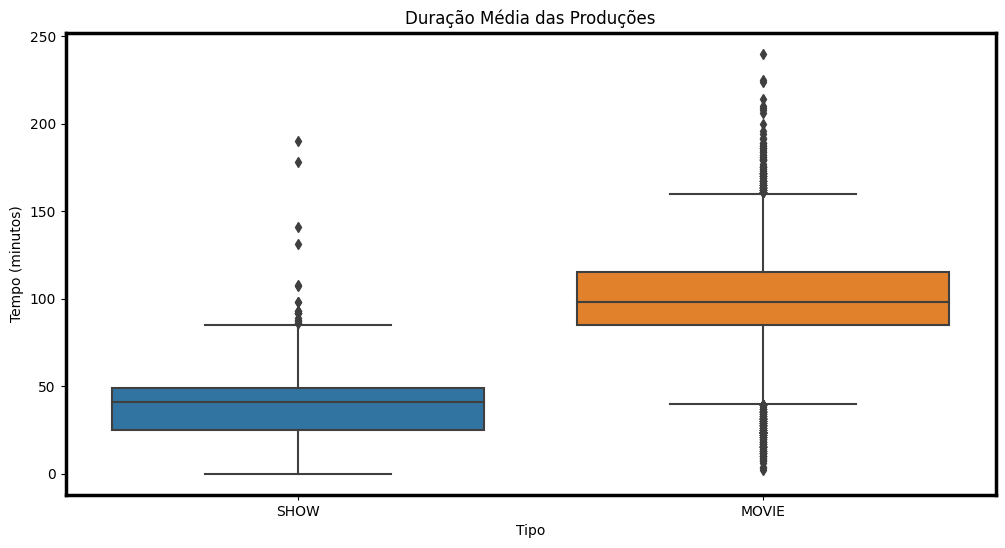

In [ ]:
plt.figure(figsize=(12, 6))

graph = sns.boxplot(y="runtime", x="type", data=netflix)

plt.xlabel('Tipo')
plt.ylabel('Tempo (minutos)')
plt.title("Duração Média das Produções")

graph = graph

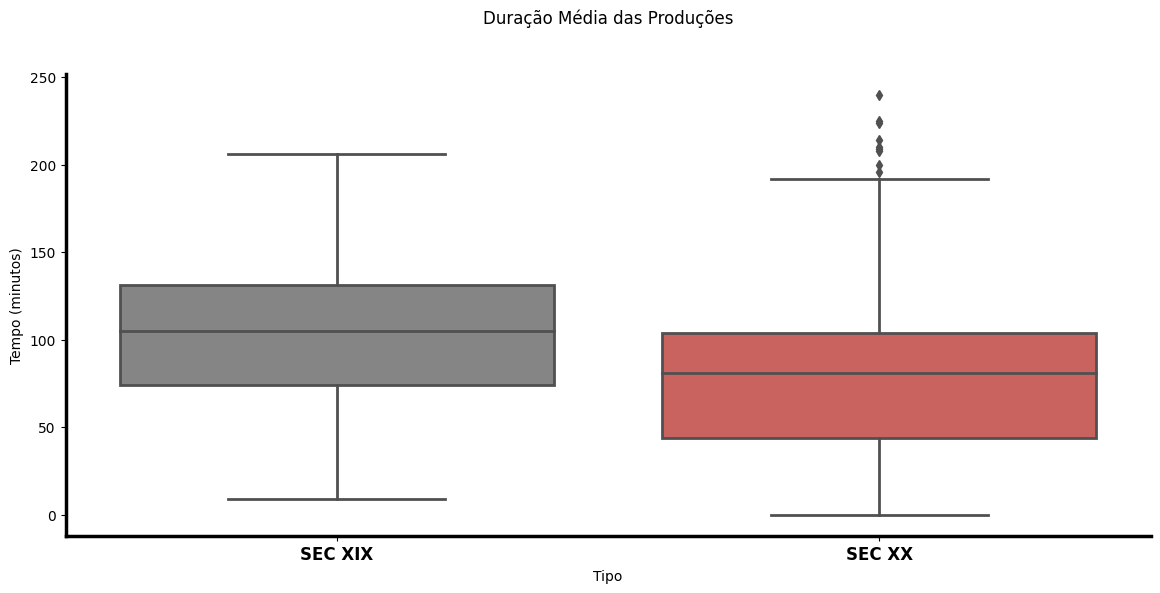

In [ ]:
## Criando uma flag para splitar o BOXPLOT
flag_seculo = lambda x: "SEC XX" if x >= 2000 else "SEC XIX"
netflix["seculo"] = netflix["release_year"].apply(flag_seculo)
netflix.sort_values(by="seculo", inplace=True)

## PLOT do gráfico
plt.figure(figsize=(14, 6))

graph = sns.boxplot(y="runtime", x="seculo", data=netflix, palette=['#858585', "#d9534f"], linewidth=2)

plt.xlabel('Tipo')
plt.ylabel('Tempo (minutos)')
plt.title("Duração Média das Produções\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

graph = graph

## Seasons

In [ ]:
print("Descrição de SEASONS das SÉRIES\n")
netflix[netflix["type"] == "SHOW"].seasons.describe()

Descrição de SEASONS das SÉRIES



count    2106.000000
mean        2.162868
std         2.689041
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        42.000000
Name: seasons, dtype: float64

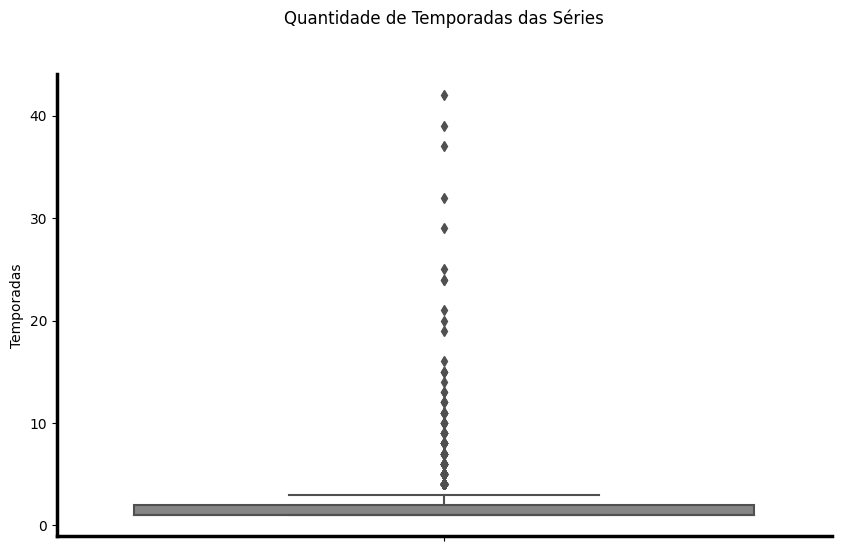

In [ ]:
plt.figure(figsize=(10, 6))

graph = sns.boxplot(y="seasons", data=netflix, color="#858585")

plt.ylabel('Temporadas')
plt.title("Quantidade de Temporadas das Séries\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

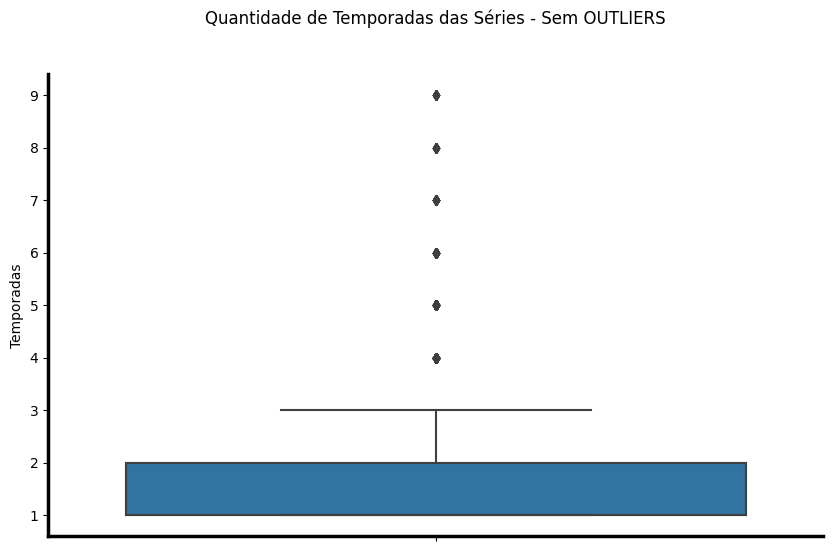

In [ ]:
plt.figure(figsize=(10, 6))

graph = sns.boxplot(y="seasons", data=netflix[netflix["seasons"] < 10])

plt.ylabel('Temporadas')
plt.title("Quantidade de Temporadas das Séries - Sem OUTLIERS\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

graph = graph

In [ ]:
outliers = netflix[netflix["seasons"] > 3].shape[0]
print(f"Séries com Quantidade de Temporadas Outliers --> {outliers}")

Séries com Quantidade de Temporadas Outliers --> 309


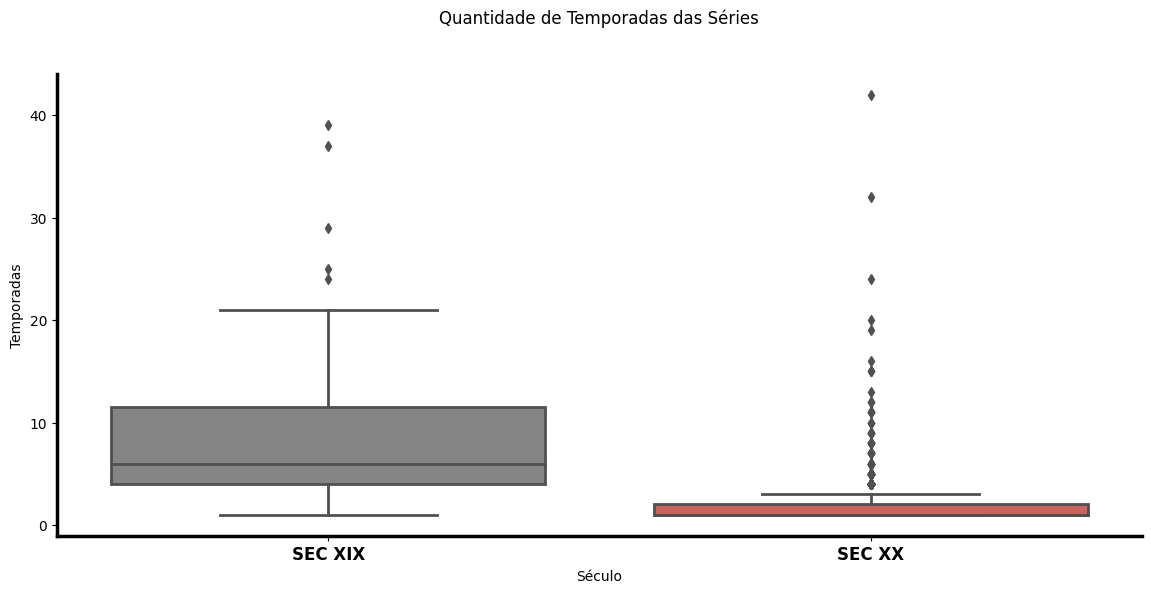

In [ ]:
flag_seculo = lambda x: "SEC XX" if x >= 2000 else "SEC XIX"
netflix["seculo"] = netflix["release_year"].apply(flag_seculo)
netflix.sort_values(by="seculo", inplace=True)

## PLOT do gráfico
plt.figure(figsize=(14, 6))

graph = sns.boxplot(y="seasons", x="seculo", data=netflix, palette=['#858585', "#d9534f"], linewidth=2)

plt.xlabel('Século')
plt.ylabel('Temporadas')
plt.title("Quantidade de Temporadas das Séries\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

## Production Countries

In [ ]:
# Criando uma lista com todos os elementos presentes na coluna "production_countries"
# posteriormente, criando um dict e um df para plotar as informações da quantidade
# de colaborações de cada país

all_countries = [country for sublist in netflix['production_countries'] for country in sublist]
countries_count = pd.DataFrame(Counter(all_countries).items(), columns=["country", "count"])

countries_count.head(3)

,country,count
0,US,2323
1,EG,49
2,IN,622


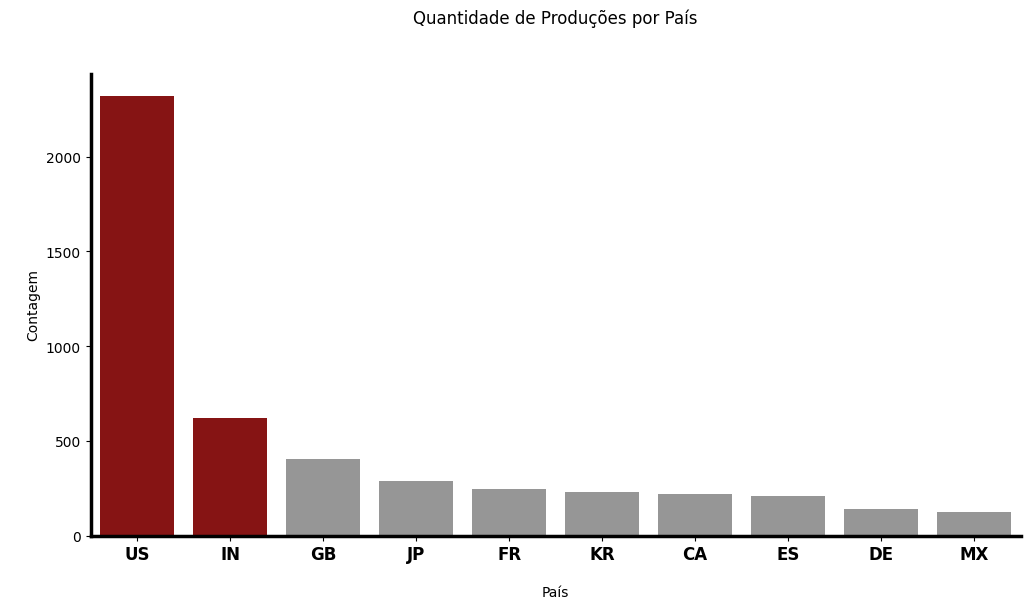

In [ ]:
countries_count.sort_values(by="count", ascending=False, inplace=True)

cinza_escuro = (150/255, 150/255, 150/255)
cores = ['#990101' if i < 2 else cinza_escuro for i in range(len(countries_count))]


plt.figure(figsize=(12,6))
graph = sns.barplot(data=countries_count.head(10), x="country", y="count", palette=cores)

plt.xlabel('\nPaís')
plt.ylabel('\nContagem')
plt.title("Quantidade de Produções por País\n\n")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

graph = graph

In [ ]:
us_in = countries_count[(countries_count["country"] == "US")|(countries_count["country"] == "IN")]["count"].sum()
total = countries_count["count"].sum()
perc_us_in = round(us_in/total, 4)*100
print(f"{perc_us_in}% foram gravados no US ou IN")

45.11% foram gravados no US ou IN


In [ ]:
# Há alguma produção gravada no BR
countries_count[countries_count.country == "BR"]

,country,count
22,BR,102


In [ ]:
# As produções BR são populares?
df_brasil = netflix[netflix['production_countries'].apply(lambda lista: "BR" in lista)]

print("Estatśticas das Avaliações das Produções Gravadas no BR (IMDB):\n")
df_brasil.imdb_score.describe()

Estatśticas das Avaliações das Produções Gravadas no BR (IMDB):



count    99.000000
mean      6.120202
std       1.319785
min       2.300000
25%       5.400000
50%       6.400000
75%       7.050000
max       8.500000
Name: imdb_score, dtype: float64

In [ ]:
df_somente_brasil = netflix[netflix['production_countries'].apply(lambda lista: "BR" in lista and len(lista)==1)]

prod_somente_brasil =  df_somente_brasil.shape[0]
prod_br = countries_count[countries_count.country == "BR"]['count'].iloc[0]

print(f"Quantidade de Produções Gravadas EXCLUSIVAMENTE no Brasil --> {prod_somente_brasil}({round(prod_somente_brasil/netflix.shape[0], 3)}%)")
print(f"Quantidade de Produções Gravadas no Brasil --> {prod_br} ({round(prod_br/netflix.shape[0], 3)}%)")

Quantidade de Produções Gravadas EXCLUSIVAMENTE no Brasil --> 90(0.015%)
Quantidade de Produções Gravadas no Brasil --> 102 (0.017%)


In [ ]:
netflix_expanded = netflix.explode('production_countries')

average_imdb_by_country = netflix_expanded.groupby('production_countries')['imdb_score'].mean()
sorted_countries = average_imdb_by_country.sort_values(ascending=False)

sorted_countries = pd.DataFrame(sorted_countries).reset_index()
sorted_countries.head(5)

,production_countries,imdb_score
0,CU,8.20
1,BS,8.00
2,CD,7.85
3,AF,7.70
4,MW,7.60


In [ ]:
for index, row in countries_count.head(5).iterrows():
  country = row["country"]
  row = sorted_countries[sorted_countries["production_countries"] == country]

  print(f"{country} - General Ranking: {row.index[0]}° - {round(row.imdb_score.values[0], 2)}")

US - General Ranking: 43° - 6.53
IN - General Ranking: 50° - 6.41
GB - General Ranking: 26° - 6.8
JP - General Ranking: 15° - 6.97
FR - General Ranking: 48° - 6.44


## Genres

In [ ]:
all_genres = [g for sublist in netflix['genres'] for g in sublist]
genres_count = pd.DataFrame(Counter(all_genres).items(), columns=["genre", "count"])

genres_count.sort_values(by="count", ascending=False, inplace=True)

In [ ]:
print(f"Gêneros Diferentes ---> {genres_count.shape[0]}\nGênero mais comum --> {genres_count.iloc[0]['genre']}")

Gêneros Diferentes ---> 19
Gênero mais comum --> drama


In [ ]:
print("Todos os gêneros:\n\n")

for i, v in enumerate(set(all_genres)):
  print(f"{i+1}. {v}")

Todos os gêneros:


1. family
2. horror
3. history
4. war
5. european
6. scifi
7. sport
8. romance
9. thriller
10. action
11. comedy
12. animation
13. documentation
14. western
15. drama
16. crime
17. reality
18. music
19. fantasy


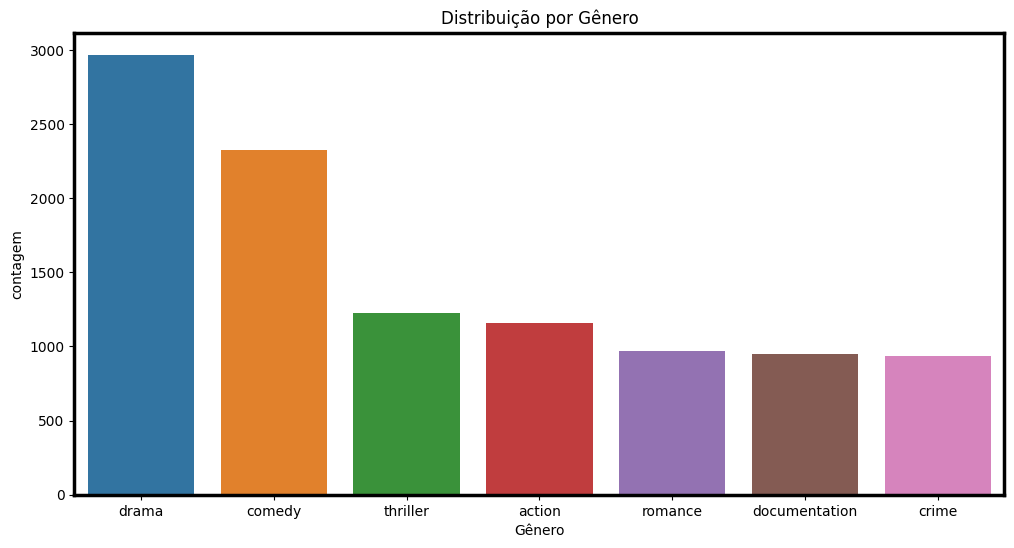

In [ ]:
plt.figure(figsize=(12,6))
graph = sns.barplot(data=genres_count.head(7), x="genre", y="count")

plt.xlabel("Gênero")
plt.ylabel("contagem")
plt.title("Distribuição por Gênero")

graph = graph

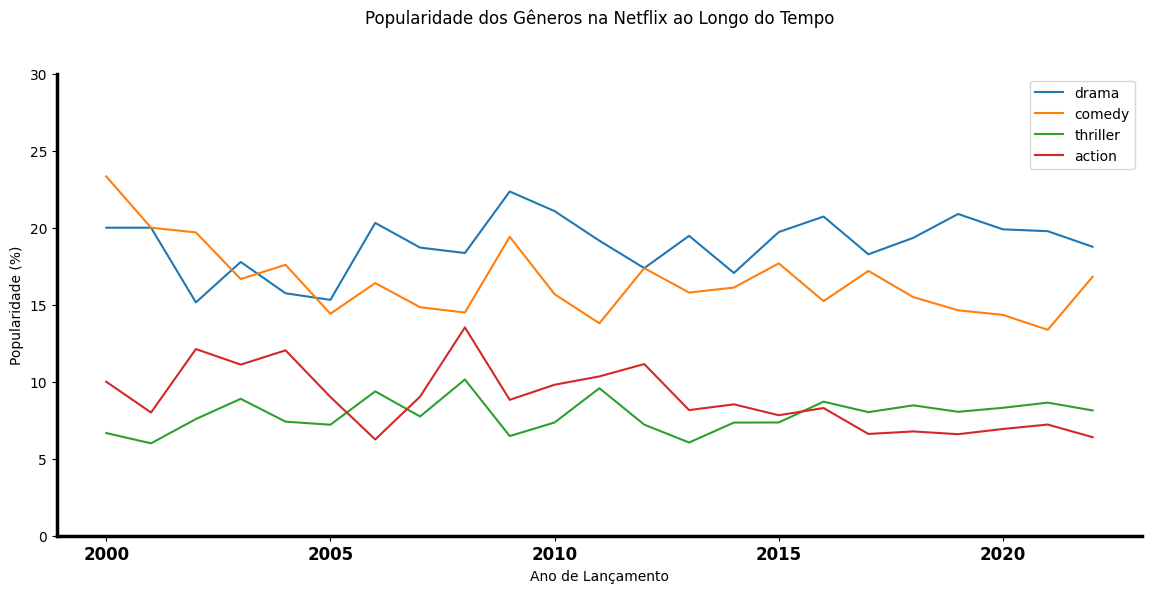

In [ ]:
genres_exploded_all = netflix.explode('genres')
genres_exploded = genres_exploded_all[genres_exploded_all.release_year >= 2000]
top_genres = genres_exploded['genres'].value_counts().nlargest(4).index

# Plotando Gráfico
plt.figure(figsize=(14, 6))

for genre in top_genres:
    df_genre = genres_exploded[genres_exploded['genres'] == genre]
    counts = (df_genre['release_year'].value_counts().sort_index() / genres_exploded['release_year'].value_counts().sort_index()) * 100
    plt.plot(counts.index, counts.values, label=genre)

plt.ylim(0, 30)

plt.title('Popularidade dos Gêneros na Netflix ao Longo do Tempo\n\n')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Popularidade (%)')

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

plt.legend()

plt.show()

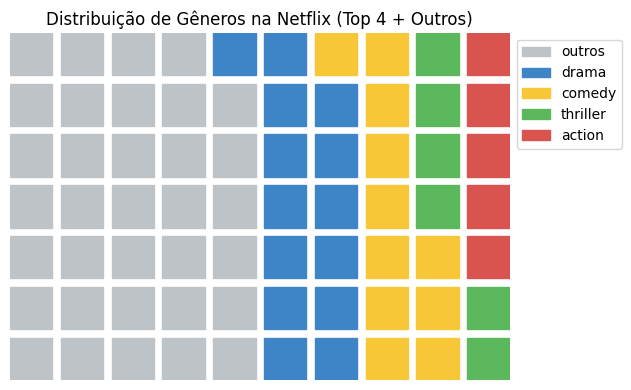

In [ ]:
## Ajustando dados
waffle_df = genres_exploded_all.genres.value_counts()
waffle_df = pd.DataFrame(waffle_df).reset_index().rename(columns={"index": "genres", "genres": "count"})
top_genres = waffle_df.genres.head(4).to_list()
waffle_df.loc[~waffle_df['genres'].isin(top_genres), 'genres'] = 'outros'
waffle_df = waffle_df.groupby("genres").sum().reset_index()
waffle_df = waffle_df.sort_values(by="count", ascending=False) # ordenando para seguir as cores do grafico anterior

colors = ['#bdc3c7', '#3d85c6', '#f7c738', '#5cb85c', '#d9534f']

## Plot
fig = plt.figure(
    FigureClass=Waffle,
    rows=7,
    columns=10,
    values=waffle_df["count"].values,
    colors=colors,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    labels=list(waffle_df['genres']),
    figsize=(16,4)
)

plt.title('Distribuição de Gêneros na Netflix (Top 4 + Outros)')

fig = fig

## Score (IMDB)

In [ ]:
print(f"Descrição da Coluna IMDB_SCORE")
netflix.imdb_score.describe()

Descrição da Coluna IMDB_SCORE


count    5368.000000
mean        6.510861
std         1.163826
min         1.500000
25%         5.800000
50%         6.600000
75%         7.300000
max         9.600000
Name: imdb_score, dtype: float64

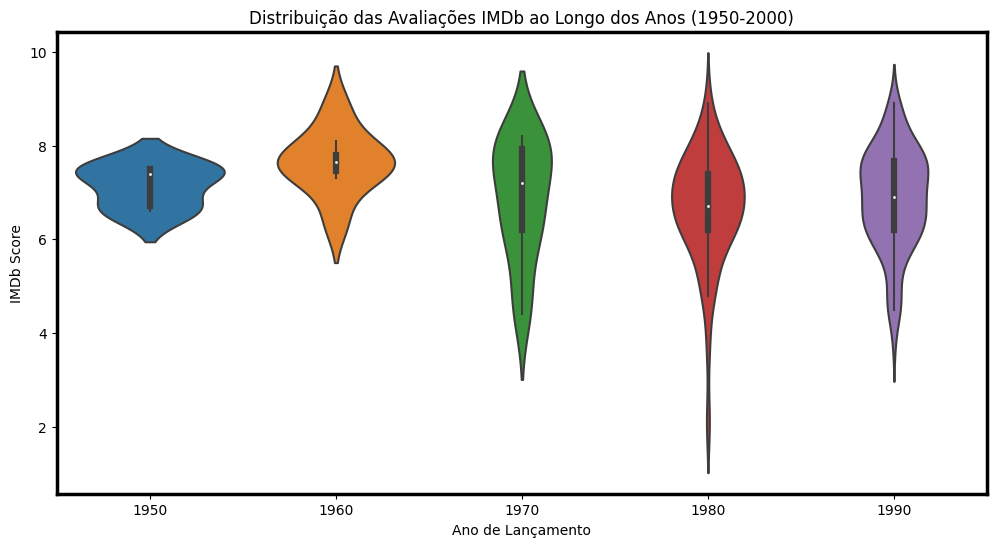

In [ ]:
# Como não há informações de avaliações da década de 40
# esse trecho será recortado do gráfico

netflix = netflix.assign(decade = netflix.release_year // 10 * 10)

plt.figure(figsize=(12, 6))
sns.violinplot(x='decade', y='imdb_score', data=netflix[(netflix["decade"]>=1950) & (netflix["decade"]<2000)])

plt.title('Distribuição das Avaliações IMDb ao Longo dos Anos (1950-2000)')
plt.xlabel('Ano de Lançamento')
plt.ylabel('IMDb Score')
plt.show()

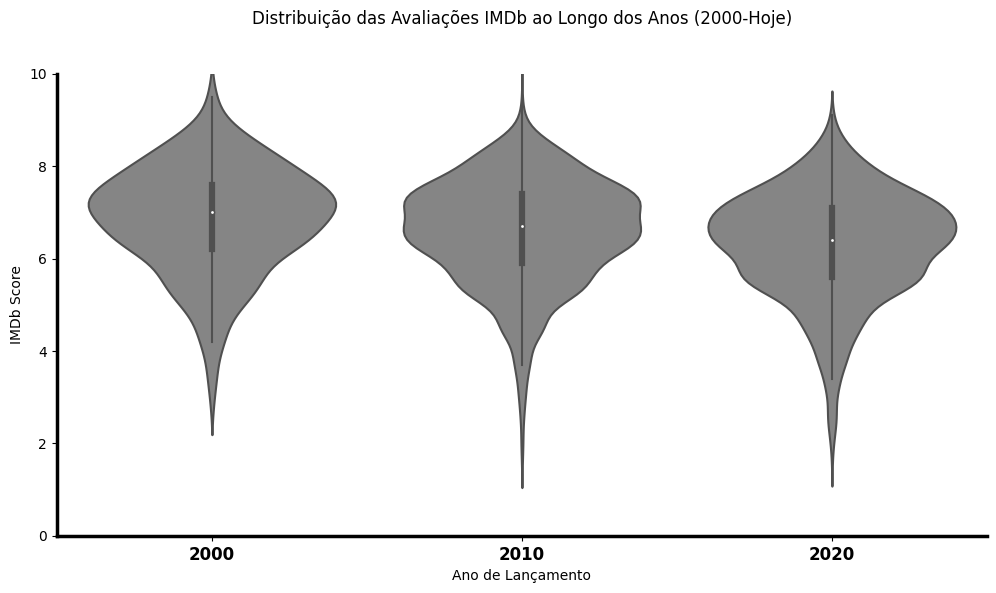

In [ ]:
netflix = netflix.assign(decade = netflix.release_year // 10 * 10)

plt.figure(figsize=(12, 6))
plt.ylim(0,10)

sns.violinplot(x='decade', y='imdb_score', data=netflix[netflix["decade"]>=2000], color="#858585")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.title('Distribuição das Avaliações IMDb ao Longo dos Anos (2000-Hoje)\n\n')
plt.xlabel('Ano de Lançamento')
plt.ylabel('IMDb Score')
plt.show()

Rating em função do Gênero




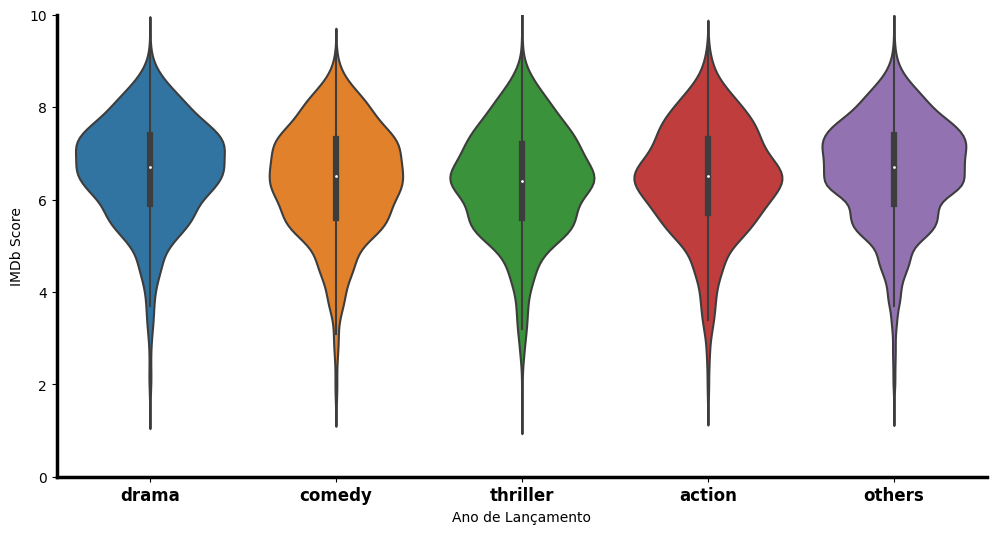

In [ ]:
print("Rating em função do Gênero\n\n")


## Ajustando df
ordem = ["drama", "comedy", "thriller", "action", "others"]

genres_violin = genres_exploded_all.copy()
genres_violin.genres = genres_violin.genres.apply(lambda x: x if x in top_genres else "others")
genres_violin = genres_violin.sort_values(by='genres', key=lambda x: x.map({valor: i for i, valor in enumerate(ordem)}))

## plot
plt.figure(figsize=(12, 6))
plt.ylim(0,10)

sns.violinplot(x='genres', y='imdb_score', data=genres_violin)

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.xlabel('Ano de Lançamento')
plt.ylabel('IMDb Score')
plt.show()

Rating em função do Tipo




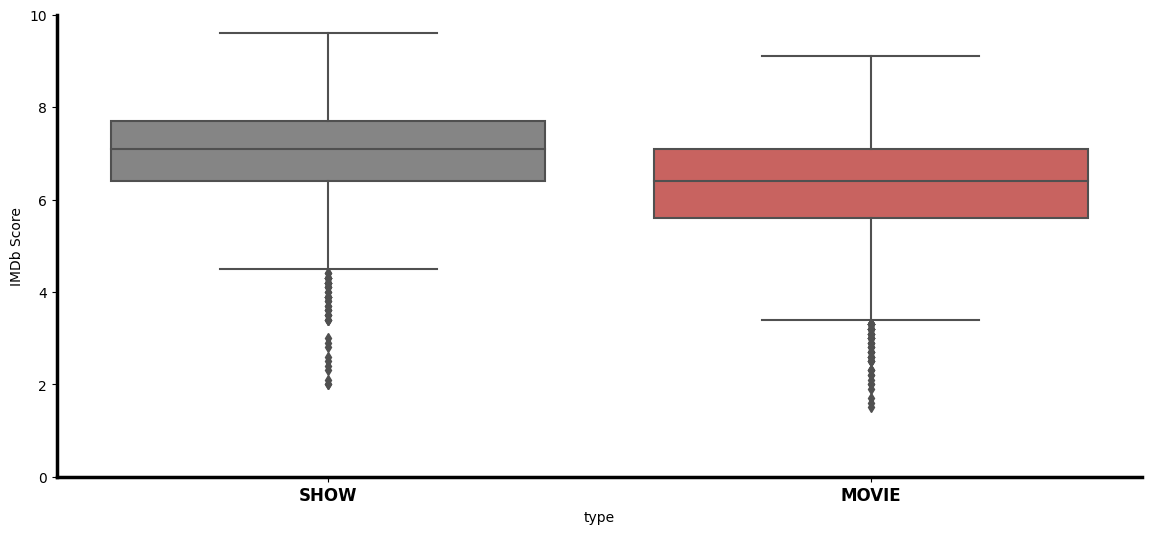

In [ ]:
print("Rating em função do Tipo\n\n")

## plot
plt.figure(figsize=(14, 6))
plt.ylim(0,10)

sns.boxplot(y='imdb_score', data=netflix, palette=['#858585', "#d9534f"], x="type")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.ylabel('IMDb Score')
plt.show()

## Scores (TMDB)

In [ ]:
print(f"Descrição da Coluna tmdb_SCORE")
netflix.tmdb_score.describe()

Descrição da Coluna tmdb_SCORE


count    5539.000000
mean        6.829175
std         1.170391
min         0.500000
25%         6.100000
50%         6.900000
75%         7.537500
max        10.000000
Name: tmdb_score, dtype: float64

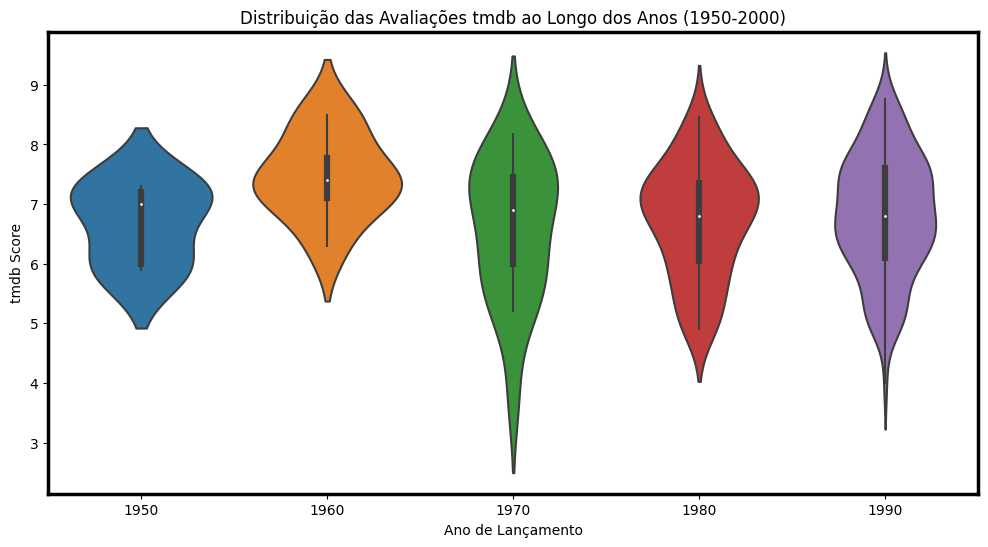

In [ ]:
# Como não há informações de avaliações da década de 40
# esse trecho será recortado do gráfico

netflix = netflix.assign(decade = netflix.release_year // 10 * 10)

plt.figure(figsize=(12, 6))
sns.violinplot(x='decade', y='tmdb_score', data=netflix[(netflix["decade"]>=1950) & (netflix["decade"]<2000)])

plt.title('Distribuição das Avaliações tmdb ao Longo dos Anos (1950-2000)')
plt.xlabel('Ano de Lançamento')
plt.ylabel('tmdb Score')
plt.show()

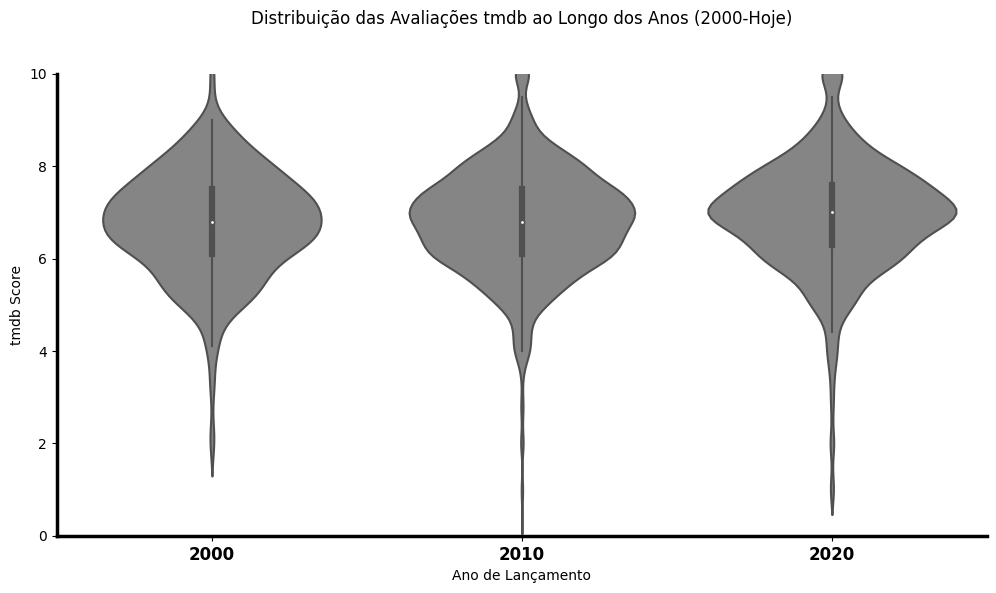

In [ ]:
netflix = netflix.assign(decade = netflix.release_year // 10 * 10)

plt.figure(figsize=(12, 6))
plt.ylim(0,10)

sns.violinplot(x='decade', y='tmdb_score', data=netflix[netflix["decade"]>=2000], color="#858585")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.title('Distribuição das Avaliações tmdb ao Longo dos Anos (2000-Hoje)\n\n')
plt.xlabel('Ano de Lançamento')
plt.ylabel('tmdb Score')
plt.show()

Rating em função do Gênero




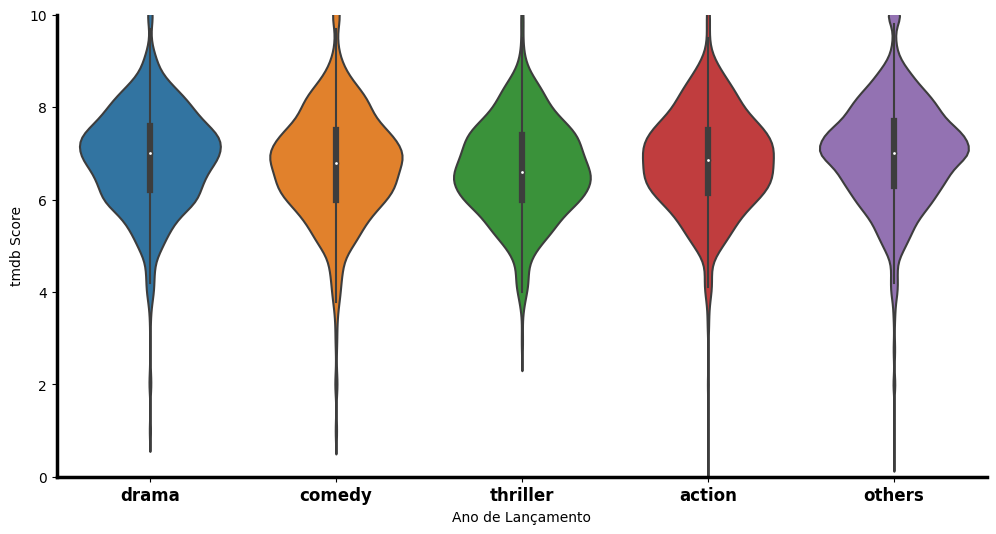

In [ ]:
print("Rating em função do Gênero\n\n")


## Ajustando df
ordem = ["drama", "comedy", "thriller", "action", "others"]

genres_violin = genres_exploded_all.copy()
genres_violin.genres = genres_violin.genres.apply(lambda x: x if x in top_genres else "others")
genres_violin = genres_violin.sort_values(by='genres', key=lambda x: x.map({valor: i for i, valor in enumerate(ordem)}))

## plot
plt.figure(figsize=(12, 6))
plt.ylim(0,10)

sns.violinplot(x='genres', y='tmdb_score', data=genres_violin)

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.xlabel('Ano de Lançamento')
plt.ylabel('tmdb Score')
plt.show()

Rating em função do Tipo




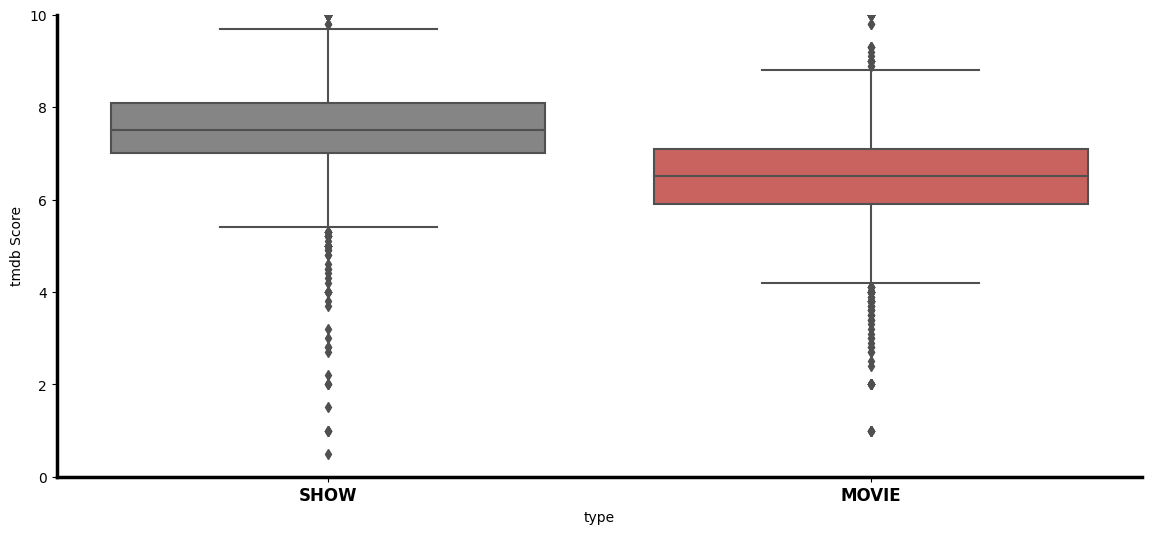

In [ ]:
print("Rating em função do Tipo\n\n")

## plot
plt.figure(figsize=(14, 6))
plt.ylim(0,10)

sns.boxplot(y='tmdb_score', data=netflix, palette=['#858585', "#d9534f"], x="type")

# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)


plt.ylabel('tmdb Score')
plt.show()

## Comparação (IMDB E TMDB)

<ipython-input-137-cb45c0eba370>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix['imdb_interval'] = netflix['imdb_score'].astype(int)
<ipython-input-137-cb45c0eba370>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix['tmdb_interval'] = netflix['tmdb_score'].astype(int)


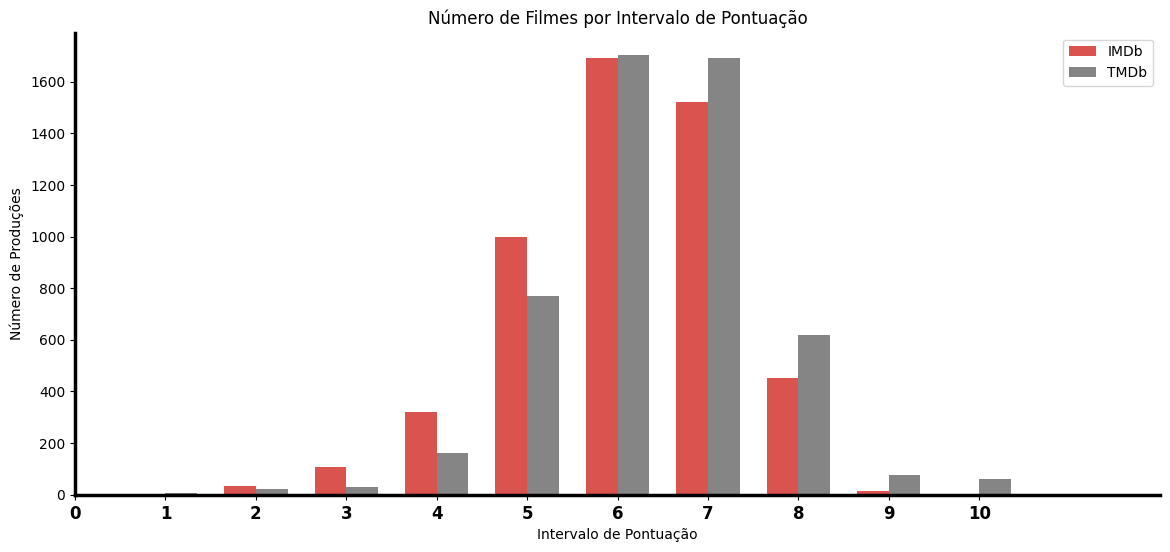

In [ ]:
## Ajustando o dataset
netflix = netflix[(~netflix['imdb_score'].isna()) & (~netflix['tmdb_score'].isna())]

netflix['imdb_interval'] = netflix['imdb_score'].astype(int)
netflix['tmdb_interval'] = netflix['tmdb_score'].astype(int)

tmdb = netflix.groupby(by="tmdb_interval").count()
imdb = netflix.groupby(by="imdb_interval").count()

imdb = imdb[["title"]].reset_index().rename(columns={"title":"contagem"})
tmdb = tmdb[["title"]].reset_index().rename(columns={"title":"contagem"})

## Gráfico
bar_width = .35
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(imdb['imdb_interval'] - bar_width/2, imdb['contagem'], bar_width, color='#d9534f', label='IMDb')
ax.bar(tmdb['tmdb_interval'] + bar_width/2, tmdb['contagem'], bar_width, color='#858585', label='TMDb')


# Ajustando Eixos
plt.xticks(fontsize=12, fontweight='bold', color="black")
ax.set_xticks(ax.get_xticks())
plt.rcParams["axes.linewidth"] = 2.50
sns.despine(bottom=False, left=False)

ax.set_title('Número de Filmes por Intervalo de Pontuação')
ax.set_xlabel('Intervalo de Pontuação')
ax.set_ylabel('Número de Produções')

plt.xticks(range(0,11,1))
ax.legend()

plt.show()

## Votes - IMDB

In [ ]:
print("Descrição dos Valores da coluna IMDB_VOTES\n")
netflix.imdb_votes.describe()

Descrição dos Valores da coluna IMDB_VOTES



count          5131.0
mean     24344.766322
std      97549.407508
min               5.0
25%             612.0
50%            2474.0
75%           10283.0
max         2294231.0
Name: imdb_votes, dtype: Float64

In [ ]:
print(f"Total de Avaliações --> {'{:,}'.format(netflix.imdb_votes.sum()).replace(',', '.')}")

Total de Avaliações --> 124.912.996


## Popularity - TMDB

In [ ]:
print("Descrição dos Valores da coluna TMDB_VOTES\n")
netflix.tmdb_popularity.describe()

Descrição dos Valores da coluna TMDB_VOTES



count    5145.000000
mean       24.062657
std        85.168508
min         0.600000
25%         3.141000
50%         7.481000
75%        17.605000
max      2274.044000
Name: tmdb_popularity, dtype: float64

## Type

In [ ]:
print("Tipos de produções:\n")
netflix["type"].value_counts()

Tipos de produções:



MOVIE    3285
SHOW     1860
Name: type, dtype: int64

# Analisando as Produções Individualmente

In [ ]:
print("Produções MAIS Avaliados - IMDB", end="\n"*2)

netflix.sort_values(by="imdb_votes", inplace=True, ascending=False)
for index, prod in enumerate(netflix.iterrows()):
  print(f"{index+1} - {prod[1].title} ({int(prod[1].imdb_votes)} avaliações)")

  if index > 8:
    break

Produções MAIS Avaliados - IMDB

1 - Inception (2294231 avaliações)
2 - Forrest Gump (2021343 avaliações)
3 - Breaking Bad (1775990 avaliações)
4 - The Dark Knight Rises (1669067 avaliações)
5 - Se7en (1606270 avaliações)
6 - Django Unchained (1472668 avaliações)
7 - The Departed (1296244 avaliações)
8 - Titanic (1146825 avaliações)
9 - Léon: The Professional (1137357 avaliações)
10 - GoodFellas (1131681 avaliações)


In [ ]:
print("Produções MENOS Avaliados (IMDB)", end="\n"*2)

netflix.sort_values(by="imdb_votes", inplace=True)
for index, prod in enumerate(netflix.iterrows()):
  print(f"{index+1} - {prod[1].title} ({int(prod[1].imdb_votes)} avaliações)")

  if index > 8:
    break

Produções MENOS Avaliados (IMDB)

1 - JAPAN SINKS: People of Hope (5 avaliações)
2 - Sitara (5 avaliações)
3 - The Birth Reborn 2 (5 avaliações)
4 - Ouija: Origin of Evil (6 avaliações)
5 - Prophetess (6 avaliações)
6 - Dance & Sing With True (6 avaliações)
7 - GHOUL (6 avaliações)
8 - Hong Kong West Side Stories (6 avaliações)
9 - Brave Animated Series (6 avaliações)
10 - Atelier (7 avaliações)


## Scores das Produções

In [ ]:
print("Produções com as MELHORES Avaliações (IMDB)", end="\n"*2)

netflix.sort_values(by="imdb_score", inplace=True, ascending=False)

for index, prod in enumerate(netflix.iterrows()):
  print(f"{index+1} - {prod[1].title} (nota: {int(prod[1].imdb_score)})")

  if index > 8:
    break

Produções com as MELHORES Avaliações (IMDB)

1 - Breaking Bad (nota: 9)
2 - Our Planet (nota: 9)
3 - Avatar: The Last Airbender (nota: 9)
4 - Reply 1988 (nota: 9)
5 - My Mister (nota: 9)
6 - Kota Factory (nota: 9)
7 - The Last Dance (nota: 9)
8 - Major (nota: 9)
9 - Okupas (nota: 9)
10 - Hunter x Hunter (nota: 9)


In [ ]:
print("Produções com as PIORES Avaliações (IMDB)", end="\n"*2)

netflix.sort_values(by="imdb_score", inplace=True, ascending=True)

for index, prod in enumerate(netflix.iterrows()):
  print(f"{index+1} - {prod[1].title} (nota: {int(prod[1].imdb_score)})")

  if index > 8:
    break

Produções com as PIORES Avaliações (IMDB)

1 - Me Against You: Mr. S's Vendetta (nota: 1)
2 - Himmatwala (nota: 1)
3 - Kyaa Kool Hain Hum 3 (nota: 1)
4 - Hajwala: The Missing Engine (nota: 2)
5 - He's Expecting (nota: 2)
6 - FRED 3: Camp Fred (nota: 2)
7 - Thomas & Friends: All Engines Go! (nota: 2)
8 - Dostana (nota: 2)
9 - Hype House (nota: 2)
10 - Time to Dance (nota: 2)


## Produções Brasileiras

In [ ]:
print("Produções gravadas no BRASIL com as PIORES Avaliações (IMDB)", end="\n"*2)

br = netflix[netflix['production_countries'].apply(lambda lista: "BR" in lista and len(lista)==1)]
br = br.sort_values(by="imdb_score", ascending=True)

for index, prod in enumerate(br.iterrows()):
  print(f"{index+1} - {prod[1].title} (nota: {int(prod[1].imdb_score)})")

  if index > 8:
    break

Produções gravadas no BRASIL com as PIORES Avaliações (IMDB)

1 - Nothing to Lose (nota: 2)
2 - Luccas Neto in: Children's Day (nota: 2)
3 - Rodrigo Sant'anna: I'm Here, I'm Queer! (nota: 2)
4 - Luccas Neto in: Summer Camp (nota: 2)
5 - Luccas Neto em: Uma Babá Muito Esquisita (nota: 3)
6 - Carnaval (nota: 4)
7 - Smother-In-Law (nota: 4)
8 - Marco Luque - We are together (nota: 4)
9 - Felipe Neto: My Life Makes No Sense (nota: 4)
10 - Cinderela Pop (nota: 4)


In [ ]:
print("Produções gravadas no BRASIL com as MELHORES Avaliações", end="\n"*2)

br = netflix[netflix['production_countries'].apply(lambda lista: "BR" in lista and len(lista)==1)]
br = br.sort_values(by="imdb_score", ascending=False)
melhores_br = br.iloc[0:3]  # usado na célula abaixo

for index, prod in enumerate(br.iterrows()):
  print(f"{index+1} - {prod[1].title} (nota: {int(prod[1].imdb_score)})")

  if index > 8:
    break

Produções gravadas no BRASIL com as MELHORES Avaliações

1 - Emicida: AmarElo - It's All for Yesterday (nota: 8)
2 - The Mechanism (nota: 8)
3 - The Beginning of Life 2: Outside (nota: 8)
4 - Girls from Ipanema (nota: 7)
5 - Birth Reborn (nota: 7)
6 - Invisible City (nota: 7)
7 - Nobody's Looking (nota: 7)
8 - Killer Ratings (nota: 7)
9 - Emicida AmarElo Live in Sao Paulo (nota: 7)
10 - Good Morning, Verônica (nota: 7)


In [ ]:
print("TOP 3 produções gravadas no Brasil")
melhores_br

TOP 3 produções gravadas no Brasil


,title,type,release_year,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,seculo,decade,imdb_interval,tmdb_interval
id,,,,,,,,,,,,,,,
tm975765,Emicida: AmarElo - It's All for Yesterday,MOVIE,2020,89,"[music, documentation]",[BR],NaN,8.5,1510,4.381,8.8,SEC XX,2020,8,8
ts78590,The Mechanism,SHOW,2018,46,"[drama, crime, thriller]",[BR],2.0,8.0,36136,8.383,7.4,SEC XX,2010,8,7
tm975616,The Beginning of Life 2: Outside,MOVIE,2020,92,[documentation],[BR],NaN,8.0,20,1.290,8.5,SEC XX,2020,8,8


In [ ]:
print("Produções gravadas no BRASIL com as MELHORES Avaliações em relação ao Ranking Geral (IMDB)", end="\n"*3)

netflix = netflix.sort_values(by="imdb_score", ascending=False).reset_index()

ranking_br = 1
for row in melhores_br.iterrows():
  nome = row[1]['title']
  id = row[0]

  ranking_imdb = netflix[netflix["id"] == id]
  ranking_imdb = ranking_imdb.index[0]

  print(f"{nome}\nRanking BR - {ranking_br}°\nRanking GERAL - {ranking_imdb}°", end="\n\n")
  ranking_br += 1

Produções gravadas no BRASIL com as MELHORES Avaliações em relação ao Ranking Geral (IMDB)


Emicida: AmarElo - It's All for Yesterday
Ranking BR - 1°
Ranking GERAL - 96°

The Mechanism
Ranking BR - 2°
Ranking GERAL - 422°

The Beginning of Life 2: Outside
Ranking BR - 3°
Ranking GERAL - 394°



## Notas dos Mais Avaliados

In [ ]:
print("Dentre as Produções com mais avaliações que a Média, os melhores avaliadas são (IMDB): \n")

media_votes = netflix.imdb_votes.mean()

netflix_mais_avaliados = netflix[netflix.imdb_votes > media_votes]

netflix_mais_avaliados = netflix_mais_avaliados.sort_values(by=["imdb_score", "imdb_votes"], ascending=False)
for index, prod in enumerate(netflix_mais_avaliados.iterrows()):
  print(f"{index+1} - {prod[1].title}\nAvaliações: {int(prod[1].imdb_votes)}\nNota Média: {prod[1].imdb_score}\n")

  if index > 8:
    break

Dentre as Produções com mais avaliações que a Média, os melhores avaliadas são (IMDB): 

1 - Breaking Bad
Avaliações: 1775990
Nota Média: 9.5

2 - Avatar: The Last Airbender
Avaliações: 303666
Nota Média: 9.3

3 - Our Planet
Avaliações: 42259
Nota Média: 9.3

4 - The Last Dance
Avaliações: 115915
Nota Média: 9.1

5 - Kota Factory
Avaliações: 69316
Nota Média: 9.1

6 - Attack on Titan
Avaliações: 325381
Nota Média: 9.0

7 - DEATH NOTE
Avaliações: 309445
Nota Média: 9.0

8 - Arcane
Avaliações: 186899
Nota Média: 9.0

9 - Hunter x Hunter
Avaliações: 92162
Nota Média: 9.0

10 - Seinfeld
Avaliações: 308824
Nota Média: 8.9



## Comparação das Avaliações (IMDB e TMBD)

In [ ]:
imdb_score_ordered = netflix.sort_values(by=["imdb_score", "imdb_votes"],  ascending=False).reset_index()
tmdb_score_ordered = netflix.sort_values(by=["tmdb_score", "tmdb_popularity"],  ascending=False).reset_index()

In [ ]:
print("Melhores Avaliados do IMDB, comparado com o TMDB", end="\n"*2)

for index, prod in enumerate(imdb_score_ordered.iterrows()):
  print(f"{prod[1].title}\nIMDB Ranking: {index+1} - Nota: {round(prod[1].imdb_score, 2)}")
  row = tmdb_score_ordered[tmdb_score_ordered["title"] == prod[1].title]
  print(f"TMDB Ranking: {row.index[0]+1} - Nota: {row.tmdb_score.values[0]}\n")

  if index > 8:
    break

Melhores Avaliados do IMDB, comparado com o TMDB

Breaking Bad
IMDB Ranking: 1 - Nota: 9.5
TMDB Ranking: 174 - Nota: 8.79

Avatar: The Last Airbender
IMDB Ranking: 2 - Nota: 9.3
TMDB Ranking: 181 - Nota: 8.7

Our Planet
IMDB Ranking: 3 - Nota: 9.3
TMDB Ranking: 156 - Nota: 8.8

Reply 1988
IMDB Ranking: 4 - Nota: 9.2
TMDB Ranking: 185 - Nota: 8.7

The Last Dance
IMDB Ranking: 5 - Nota: 9.1
TMDB Ranking: 462 - Nota: 8.2

Kota Factory
IMDB Ranking: 6 - Nota: 9.1
TMDB Ranking: 397 - Nota: 8.3

Major
IMDB Ranking: 7 - Nota: 9.1
TMDB Ranking: 523 - Nota: 8.188

My Mister
IMDB Ranking: 8 - Nota: 9.1
TMDB Ranking: 140 - Nota: 8.9

Attack on Titan
IMDB Ranking: 9 - Nota: 9.0
TMDB Ranking: 211 - Nota: 8.6

DEATH NOTE
IMDB Ranking: 10 - Nota: 9.0
TMDB Ranking: 203 - Nota: 8.664



In [ ]:
print("Melhores Avaliados do IMDB (Mais Avaliações que a Média), comparado com o TMDB", end="\n"*2)

media_votes = netflix.imdb_votes.mean()
netflix_mais_avaliados = netflix[netflix.imdb_votes > media_votes]
netflix_mais_avaliados = netflix_mais_avaliados.sort_values(by=["imdb_score", "imdb_votes"], ascending=False)


for index, prod in enumerate(netflix_mais_avaliados.iterrows()):
  print(f"{prod[1].title}\nIMDB Ranking: {index+1} - Nota: {round(prod[1].imdb_score, 3)}")
  row = tmdb_score_ordered[tmdb_score_ordered["title"] == prod[1].title]
  print(f"TMDB Ranking: {row.index[0]+1} - Nota: {row.tmdb_score.values[0]}\n")

  if index > 8:
    break

Melhores Avaliados do IMDB (Mais Avaliações que a Média), comparado com o TMDB

Breaking Bad
IMDB Ranking: 1 - Nota: 9.5
TMDB Ranking: 174 - Nota: 8.79

Avatar: The Last Airbender
IMDB Ranking: 2 - Nota: 9.3
TMDB Ranking: 181 - Nota: 8.7

Our Planet
IMDB Ranking: 3 - Nota: 9.3
TMDB Ranking: 156 - Nota: 8.8

The Last Dance
IMDB Ranking: 4 - Nota: 9.1
TMDB Ranking: 462 - Nota: 8.2

Kota Factory
IMDB Ranking: 5 - Nota: 9.1
TMDB Ranking: 397 - Nota: 8.3

Attack on Titan
IMDB Ranking: 6 - Nota: 9.0
TMDB Ranking: 211 - Nota: 8.6

DEATH NOTE
IMDB Ranking: 7 - Nota: 9.0
TMDB Ranking: 203 - Nota: 8.664

Arcane
IMDB Ranking: 8 - Nota: 9.0
TMDB Ranking: 100 - Nota: 9.081

Hunter x Hunter
IMDB Ranking: 9 - Nota: 9.0
TMDB Ranking: 146 - Nota: 8.8

Seinfeld
IMDB Ranking: 10 - Nota: 8.9
TMDB Ranking: 363 - Nota: 8.301



## Filme mais Longo

In [ ]:
max_runtime = netflix.runtime.max()
netflix[netflix.runtime == max_runtime]

,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
tm469911,Bonnie & Clyde,MOVIE,"Based on the true story of Clyde Barrow, a cha...",2013,PG-13,240,"['drama', 'crime', 'european']",['AT'],NaN,tt2374851,NaN,NaN,0.933,7.5


## Filme mais antigo

In [ ]:
min_year = netflix.release_year.min()
netflix[netflix.release_year == min_year]

,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.6,NaN


## Melhor Avaliado

In [ ]:
median_votes = netflix.imdb_votes.median()
max_score = netflix[netflix.imdb_votes >= median_votes].imdb_score.max()

netflix[netflix.imdb_score >= max_score]

,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
ts4,Breaking Bad,SHOW,"When Walter White, a New Mexico chemistry teac...",2008,TV-MA,48,"['drama', 'crime', 'thriller']",['US'],5.0,tt0903747,9.5,1775990.0,353.848,8.79
ts160526,Khawatir,SHOW,A TV show devoted to help young people to be m...,2005,TV-14,19,['reality'],[],11.0,tt3062514,9.5,3115.0,NaN,NaN
ts265844,#ABtalks,SHOW,#ABtalks is a YouTube interview show hosted by...,2018,TV-PG,68,[],[],1.0,tt12635254,9.6,7.0,NaN,NaN


## Maior Série

In [ ]:
max_season = netflix.seasons.max()

netflix[netflix.seasons >= max_season]

,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
ts20981,Survivor,SHOW,A reality show contest where sixteen or more c...,2000,TV-PG,48,['reality'],['US'],42.0,tt0239195,7.4,24687.0,54.19,7.4


# Correlação dos Scores

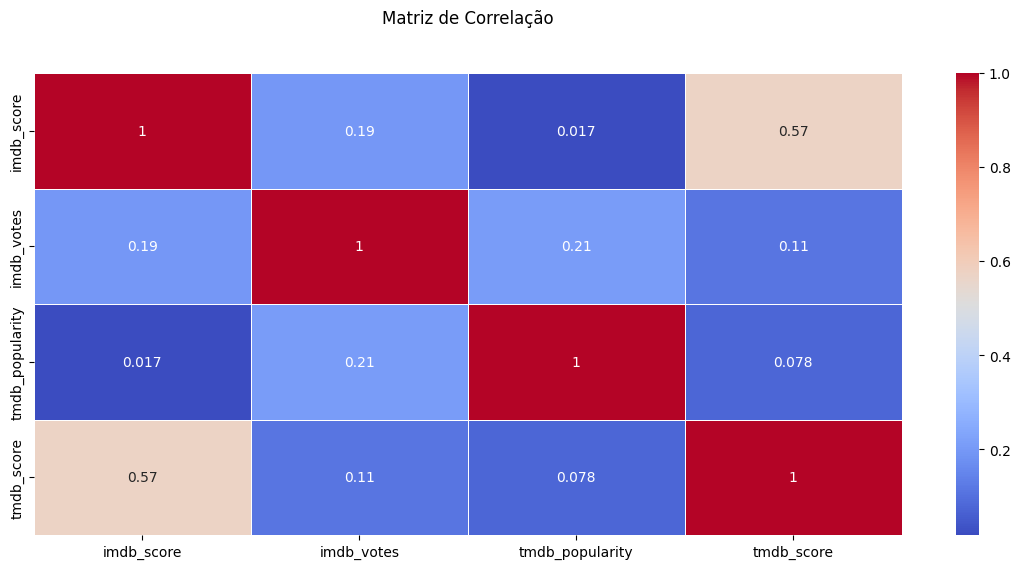

In [ ]:
corr = netflix[["imdb_score", "imdb_votes", "tmdb_popularity", "tmdb_score"]].corr()

plt.figure(figsize=(14, 6))
graph = sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlação\n\n')

graph = graph

# Validação de Hipóteses

## Diminuição do Runtime

*P>|t|* é o p-valor associado ao teste *t* para cada coeficiente. Um valor

*P>|t|* menor que um nível de significância pré-definido (como 0.05) sugere que o coeficiente é estatisticamente significativo.

In [ ]:
movies = netflix[netflix['type'] == 'MOVIE']

mean_runtime_by_year = movies.groupby('release_year')['runtime'].mean().reset_index()

X = mean_runtime_by_year['release_year']  # Variável independente (ano)
y = mean_runtime_by_year['runtime']       # Variável dependente (tempo de duração)

X = sm.add_constant(X)  # Adicionando uma constante para o termo independente
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                runtime   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     19.43
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           4.38e-05
Time:                        22:58:41   Log-Likelihood:                -263.46
No. Observations:                  62   AIC:                             530.9
Df Residuals:                      60   BIC:                             535.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1128.0000    229.632      4.912   

In [ ]:
### p-value menor que 0.05

## Mais Gêneros, melhor avaliação

In [204]:
netflix.dropna(inplace=True)
netflix['num_genres'] = netflix['genres'].apply(lambda x: len(x))

# Realizando o teste de ANOVA
result = f_oneway(*[group['imdb_score'] for name, group in netflix.groupby('num_genres')])

print(f"Valor F: {round(result.statistic, 4)}")
print(f"Valor p: {round(result.pvalue, 4)}")

Valor F: 2.84
Valor p: 0.0017


In [ ]:
# Para um nível de significância de 0.05, pode descartar a hipótese nula.